# **Project: Vehicle Identification** 

---

 [![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
 
 
 ## 1. Introduction
 
 The goal of this project is to develop classifier, which will be able to detect vehicles while driving using images from a dash cam. The vehicles should be identified correctly and performance should be sufficent to allow for  5-6 fps processing.
 
 One important assumption is the choice of algorithms used to identify cars on the road - in this project we use Computer Vision, especially Histogram of Oriented Gradients together with SVM based classification (SVC).
 
 This report is divided into following sections:
 * SVC model training
 * Features engineering
 * Image analysis
 * Video pipeline
 * Summary
 
 ## 2. SVC model training
 ### 2.1 Training data
 I decided to use only the datasets provided for this project - did not use the recently released dataset from Udacity.
 
 For each image, I extracted following features (see get_features in hog_utils.py for details):
 * color histogram
 * spatial features
 * HOG descriptor
 Those features will be used to train SVC classified
 
 ### 2.2 Train and test split
 I decided to have 20% of data in the test set. In case of GTI data, there was a problem pointed out in the course materials - some of the pictures were taken in series - there was the same car on them and differences were minimal. This means that in case of spreading such pictures between train and test set, they could disturb training process - classifier will "memorize" them and show better accuracy than with real data.
 
 To deal with this issue, I manually splitted the GTI sets - for each set i found a picture, which splitted the set with 80/20 rule but without spreading the same pictures across train and test set - see model_check in hog_utils.py for more details.
 
 All test and train data are scaled and shuffled before training
 
 ### 2.3 Training
 The SVC classifier is trained using default parameters and I calculated accuracy using test set. This allows me to comapre different models and select the one with best accuracy. An assumption about choosing accuracy as the metric for selecting model should be discussed in the future taking into account the requirements for the classifier.
 ## 3 Feature engineering
 each feature has its parameters, which can impact the classifier accuracy, additionally selecting wrong parameters can result in bigger efatures and therefore longer processing time. To select best parameters I did the following:
* color histogram: I experimented manually setting different number of bins and decided to go with 32 bins
* spatial features  - I used similar procedure as in case of color histogram
* HOG has 3 omportant parameters and tuning them manually was too hard, especially with importance of color model selection. Therefore I decided to perform parameter searching.
### 3.1 Searching of parameter space
I made cartesian product of the possible parameter values and for each combination trained a calssifier, calculated its accuracy and features size. Parameter values:
* HOG pixels per cell: 8, 12, 16
* HOG cells per block: 2, 3, 4
* HOG orientations: 6, 8, 9, 10, 12
* Color model: HLS and YCbCr - I made preselection using exploratory analysis

Above values gave me 90 combinations to check, here comes top 10 results:


In [50]:
%matplotlib inline
import cv2
from hog_utils import get_hog, color_hist, bin_spatial, slider, add_heat, apply_threshold, draw_labeled_bboxes, show3x1
import pickle
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.measurements import label
import os
model_data = pickle.load(open('model_data.p', 'rb'))
import pandas as pd
from IPython.display import HTML


In [51]:
hog_space = pd.read_csv(open('hog_space.csv', 'r'), names=['pix_per_cell', 'cells_per_block', 'orientations', 'size',
                                                           'color_model', 'accuracy'], header = None)

In [52]:
top10 = hog_space.sort_values('accuracy', ascending = False)[0:9]
HTML(top10.to_html(index=False))


pix_per_cell,cells_per_block,orientations,size,color_model,accuracy
8,3,9,9612,HLS,0.991019
8,2,12,7920,YCbCr,0.990457
8,2,10,6744,YCbCr,0.989896
8,2,12,7920,HLS,0.989615
16,2,12,2160,HLS,0.989054
8,2,10,6744,HLS,0.989054
8,3,12,12528,HLS,0.989054
8,3,12,12528,YCbCr,0.988774
16,3,12,2160,HLS,0.988212


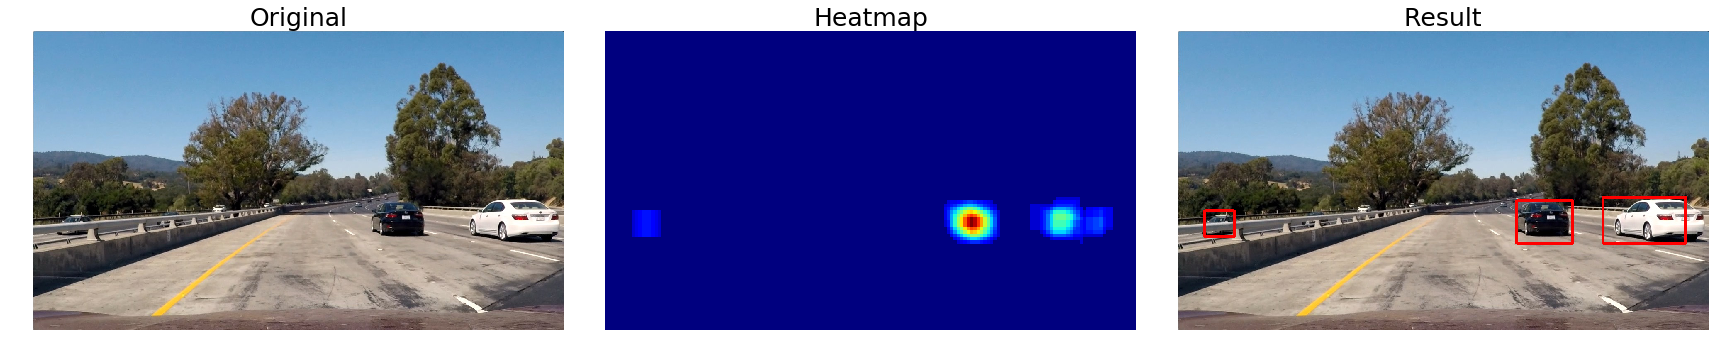

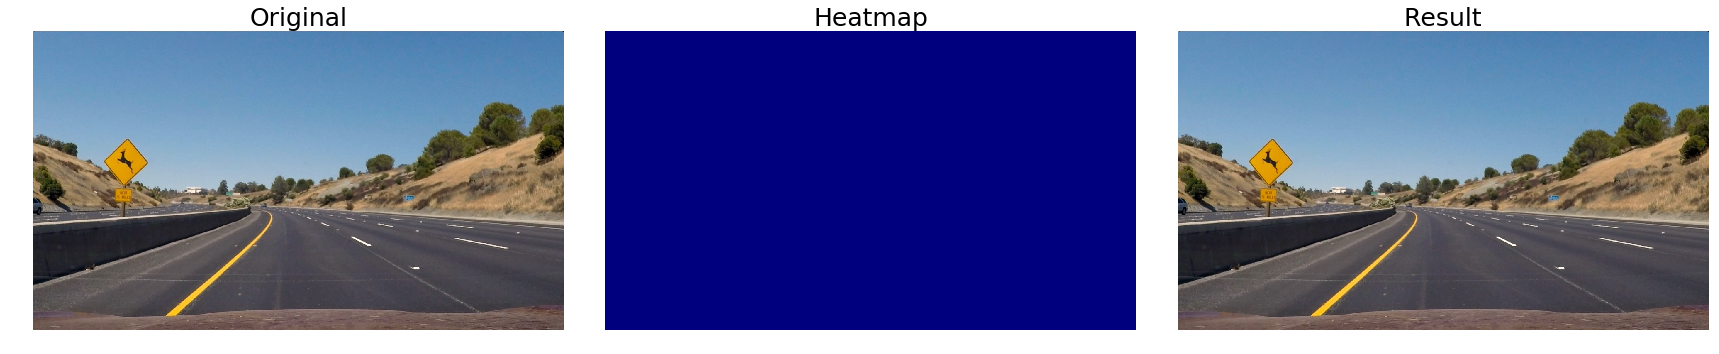

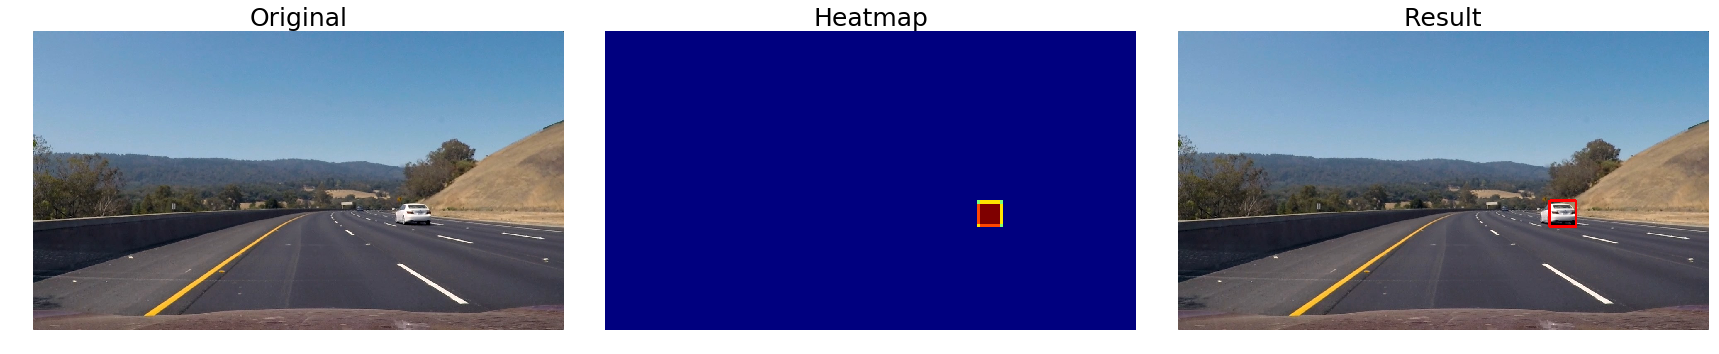

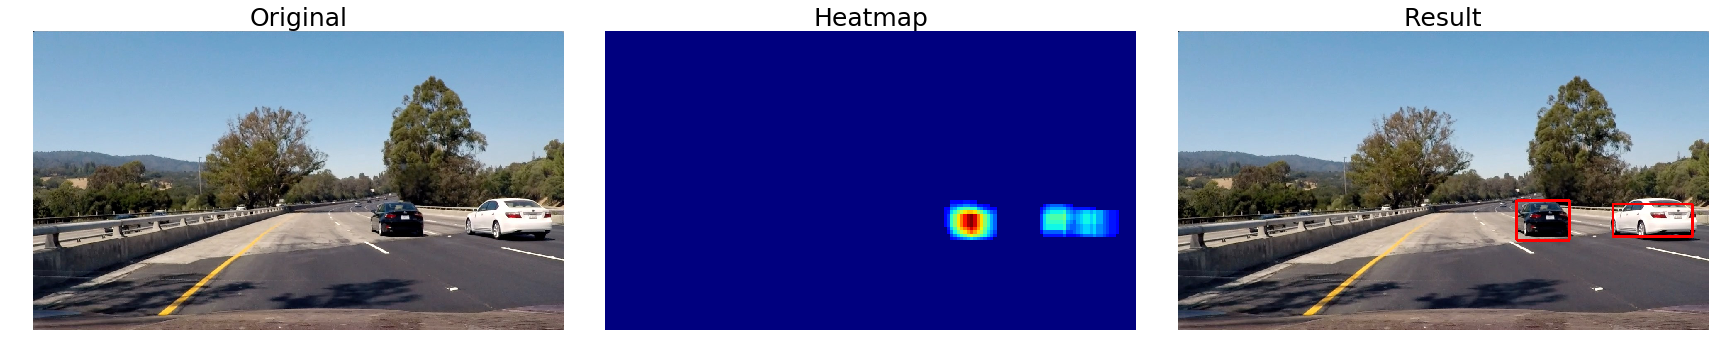

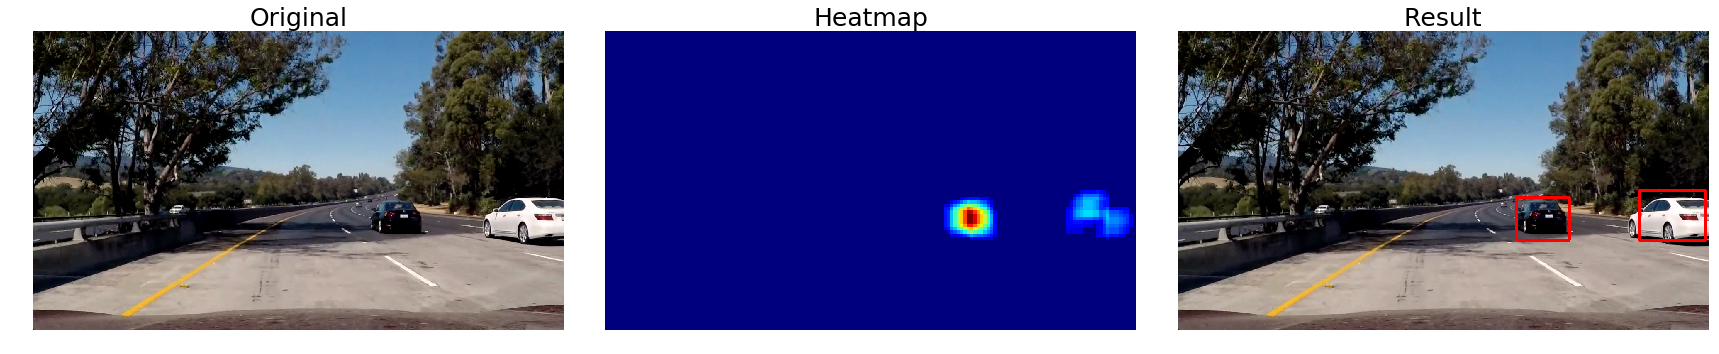

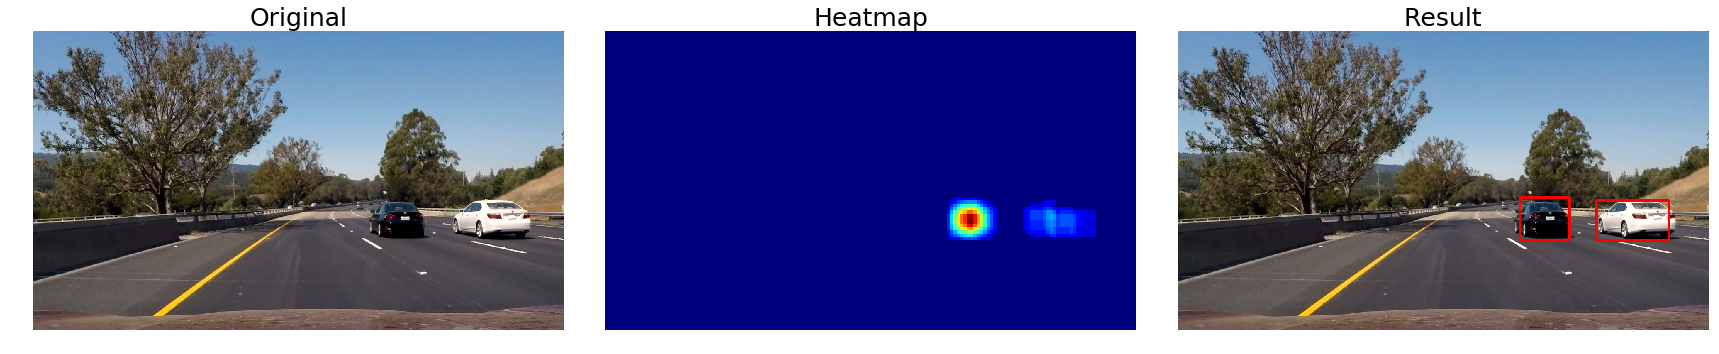

In [22]:
directory = 'test_images'
for f in os.listdir(directory):
    if f.endswith('.jpg'):
        img = cv2.imread(directory + '/' + f)
        s0 = slider(img, (None, None), (300, 512), model = model_data, step = 8)
        s1 = slider(img, (None, None), (350, None), model = model_data, scale = 1/2, step = 32)
        predict0 = s0.predict()
        predict1 = s1.predict()
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat, predict0)
        heat = add_heat(heat, predict1)
        heat = apply_threshold(heat, 2)
        labels = label(heat)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show3x1(img, heat, draw_img, 'Original', 'Heatmap', 'Result')

In [17]:
img = cv2.imread('test_images/test1.jpg')
s0 = slider(img, (None, None), (250, 512), model = model_data, step = 8)
s1 = slider(img, (None, None), (350, None), model = model_data, scale = 1/2, step = 32)




In [18]:
%time predict0 = s0.predict()


Wall time: 20.5 s


In [19]:
%time predict1 = s1.predict()

Wall time: 390 ms


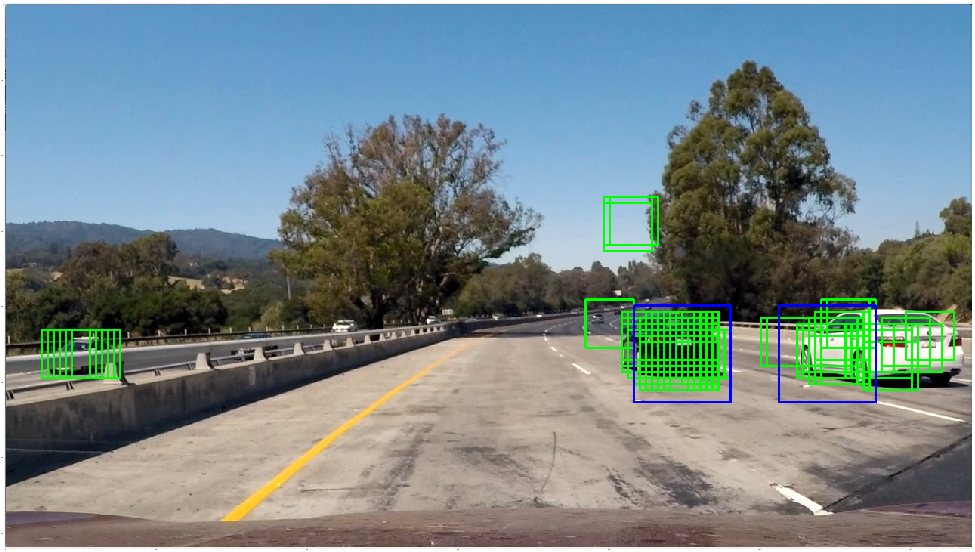

In [20]:
draw = img.copy()
plt.figure(figsize=(128, 72), dpi=10, facecolor='w', edgecolor='k')

for p1, p2 in predict0:
    cv2.rectangle(draw, p1, p2, (0, 255, 0), 2)

for p1, p2, in predict1:
    cv2.rectangle(draw, p1, p2, (255, 0, 0), 2)

draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
plt.imshow(draw)
plt.show()

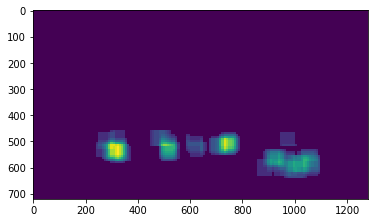

In [7]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, predict0)
heat = add_heat(heat, predict1)
heat = apply_threshold(heat, 2)
plt.imshow(heat)

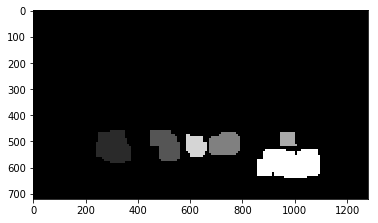

In [8]:
labels = label(heat)
plt.imshow(labels[0], cmap='gray')

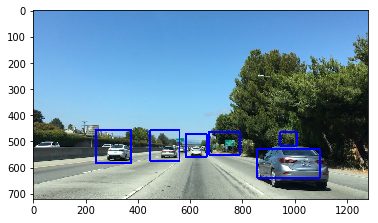

In [10]:
draw_img = draw_labeled_bboxes(np.copy(img), labels)
draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
# Display the image
plt.imshow(draw_img)